# Physical activity and sleep notebook:

### Contents:

1. Loading dependencies
2. Processing and extraction

## 1. Loading dependencies

In [1]:
#Package loading
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from datetime import datetime, date, time, timedelta

import matplotlib.pyplot as plt
import matplotlib.pylab as pl
from matplotlib import rcParams
from matplotlib.dates import DateFormatter
from matplotlib import rc
from matplotlib.dates import date2num
from IPython import display
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
import matplotlib.dates as dates
%matplotlib inline

from scipy import stats as sps
from scipy.interpolate import interp1d

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor

import statsmodels.api as sm
from CosinorPy import file_parser, cosinor, cosinor1

import glob
import math
from os import path
from collections import defaultdict
import nolds
import pyActigraphy as pyAc
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (14,8)
plt.rcParams['font.size'] = 18
plt.rcParams['image.cmap'] = 'plasma'
plt.rcParams['axes.linewidth'] = 2
plt.rc('font', family='serif')

## 2. Processing and extraction

In [10]:
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')
from preprocessing import Subject

filelist = ['DummyBVS1.csv','DummyBVS2.csv','DummyBVS3.csv','DummyBVS4.csv', 'DummyBVS5.csv']#,'dummybbvs_2.csv']#,'dummy2_full.csv']#,'dummy1_full.csv']#,
           # 'dummybbvs_1.csv', 'dummybbvs_2.csv']
quantiles=[0.25,0.30,0.35,0.4,0.45,0.5,0.55,0.6]
lengths=[10,15,20,25,30,35]

def get_data(filelist):
    d = defaultdict(dict)
    for idx, filename in enumerate(filelist):
        d[idx] = Subject(filename)
        d[idx].get_METS()
        #d[idx].get_HRV()
        d[idx].get_PA()
        #Gets sleep labels
        d[idx].get_sleep_grid(q_sleep=quantiles, bed_time = '20:00',wake_time = '12:00', lengths = lengths)
        #Gets van hees labels
        d[idx].get_vanhees(limb='dw',q_sleep=0.10, bed_time = '20:00',wake_time = '12:00',min_len = 20, gaps=60, factor=15)
        #d[idx].get_vanhees(limb='ndw',q_sleep=0.10, bed_time = '20:00',wake_time = '12:00',min_len = 20, gaps=60, factor=15)
        #d[idx].get_vanhees(limb='thigh',q_sleep=0.10, bed_time = '20:00',wake_time = '12:00',min_len = 20, gaps=60, factor=15)
        #d[idx].get_windows()
        #d[idx].get_SRI(q_sleep=quantiles)
        #d[idx].get_ARI()
        #d[idx].get_SSA()
        #d[idx].get_nonlinear()
        #Depends on running METS,PA,sleep, windows, SRI, first
        #d[idx].get_daily_stats()
    return d

d = get_data(filelist)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
diaries = pd.read_csv('Data/dummydiaries.csv',index_col='id',header=0,dayfirst=True)
diaries_t = diaries.transpose().reset_index().rename(columns={'index':'var'}).drop([0,1])
diary = defaultdict(dict)
for idx in range(5):
    diary[idx+1] = diaries_t['DummyBVS'+str(idx+1)].dropna()
    diary_sleep = [] 
    diary_wake = [] 
    for i in range(len(diary[idx+1])): 
        if i % 2: 
            diary_wake.append(diary[idx+1][i+2]) 
        else : 
            diary_sleep.append(diary[idx+1][i+2])
    diary[idx+1] = pd.DataFrame(data={'sleep_onset':pd.Series(pd.to_datetime(diary_sleep,dayfirst=True)),
                                      'sleep_offset':pd.Series(pd.to_datetime(diary_wake,dayfirst=True))})
    diary[idx+1]['TST'] = pd.to_datetime(diary[idx+1]['sleep_offset'],dayfirst=True) - pd.to_datetime(diary[idx+1]['sleep_onset'],dayfirst=True)
    diary[idx+1] = diary[idx+1].dropna()
    
#Labels a diary window where sleep=1, wake=0 - for calculating MSE
def diary_annot(self, sleep_diary):
    self.data['diary_sleep'] = np.nan
    for timeon in sleep_diary['sleep_onset'].values:
        if (timeon in self.data['diary_sleep'].index.values):
            self.data['diary_sleep'].loc[timeon] = 1
    for timeoff in sleep_diary['sleep_offset'].values:
        if (timeoff in self.data['diary_sleep'].index.values):
            self.data['diary_sleep'].loc[timeoff] = 0
    self.data['diary_sleep'] = self.data['diary_sleep'].fillna(method='ffill')
    self.data['diary_sleep'] = self.data['diary_sleep'].fillna(method='bfill')
    return self

for idx in d.keys():
    diary_annot(d[idx], diary[idx+1])

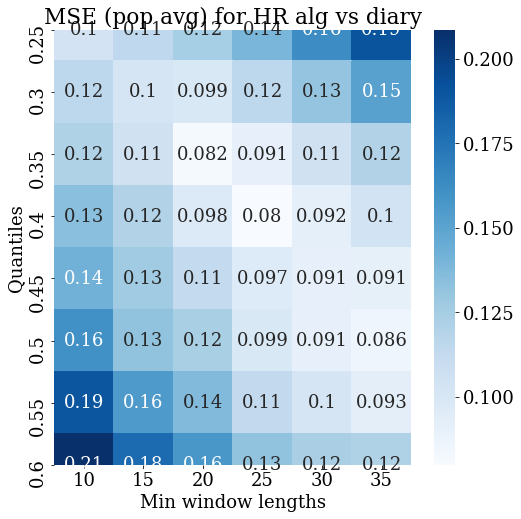

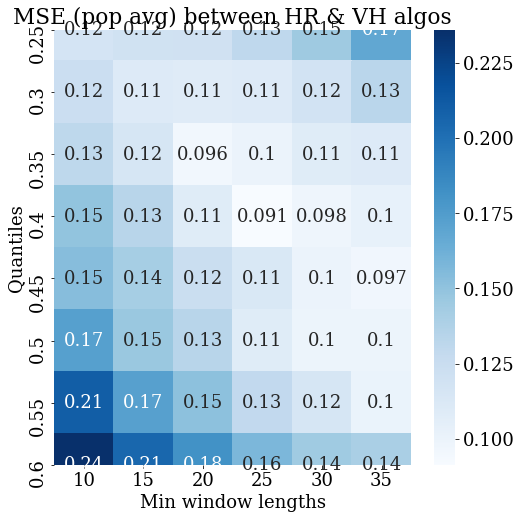

In [46]:
from sklearn.metrics import mean_squared_error 

#plt.plot(d[0].data['diary_sleep'],color='red')
#plt.plot(-(d[0].data['sleep_window_0.35_20']-2),color='blue')
#plt.plot(-(d[0].data['sleep_window_0.3_15']-2),color='green')
#plt.plot(d[0].data['sleep_window_dw'])
#plt.show()

mse = defaultdict(dict)
zero_data = np.zeros(shape=(len(quantiles),len(lengths)))
hrd_sum = pd.DataFrame(zero_data, columns=lengths, index=quantiles)
hrvh_sum = pd.DataFrame(zero_data, columns=lengths, index=quantiles)

for idx in d.keys():
    vhd = mean_squared_error(d[idx].data['diary_sleep'],d[idx].data['sleep_window_dw'])
    hrd = pd.DataFrame()
    hrvh = pd.DataFrame()
    for qtl in quantiles:
        for lens in lengths:
            hrd.loc[qtl,lens] = mean_squared_error(d[idx].data['diary_sleep'],
                                                       -(d[idx].data['sleep_window_'+str(qtl)+'_'+str(lens)]-2))
            hrvh.loc[qtl,lens] = mean_squared_error(-(d[idx].data['sleep_window_'+str(qtl)+'_'+str(lens)]-2),
                                                        d[idx].data['sleep_window_dw'])
    mse[idx]['vhd'] = vhd
    mse[idx]['hrd'] = hrd
    mse[idx]['hrvh'] = hrvh
    hrd_sum = hrd_sum + hrd 
    hrvh_sum = hrvh_sum + hrvh
    
hrd_mean = hrd_sum / len(d.keys())
hrvh_mean = hrvh_sum / len(d.keys())

#print(mse[0]['hrd'])
#print(mse[1]['hrd'])
#print(hrd_mean)

rcParams['figure.figsize'] = 8,8
f = sns.heatmap(hrd_mean, cmap="Blues",annot=True)
f.set_ylabel('Quantiles')
f.set_xlabel('Min window lengths')
f.set_title('MSE (pop avg) for HR alg vs diary')
plt.show(f)

rcParams['figure.figsize'] = 8,8
f = sns.heatmap(hrvh_mean, cmap="Blues",annot=True)
f.set_ylabel('Quantiles')
f.set_xlabel('Min window lengths')
f.set_title('MSE (pop avg) between HR & VH algos')
plt.show(f)

        vh       hr        d  bax_hrd  bax_vhd bax_hrvh  bay_hrd  bay_vhd  \
0  415.556  391.111    442.5  416.806  429.028  403.333 -51.3889 -26.9444   
1  413.556  359.667  499.375  429.521  456.465  386.611 -139.708 -85.8194   
2  464.375  361.875  498.625   430.25    481.5  413.125  -136.75   -34.25   
3    400.7  432.364  458.333  445.348  429.517  416.532 -25.9697 -57.6333   
4  390.222  411.444      450  430.722  420.111  400.833 -38.5556 -59.7778   

  bay_hrvh  
0 -24.4444  
1 -53.8889  
2   -102.5  
3  31.6636  
4  21.2222  


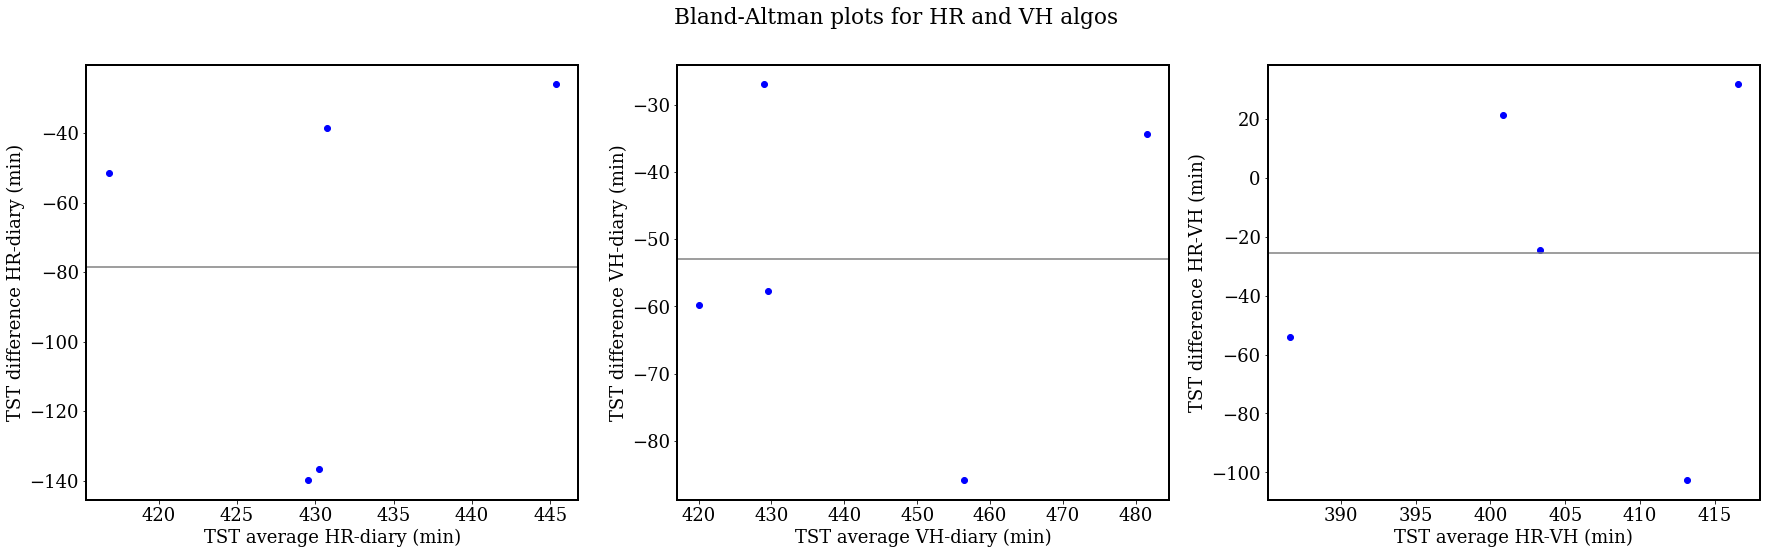

In [47]:
#Bland-Altman plots with the optimised HR parameters (in this case q=0.5, len=25)
TST_avg = pd.DataFrame(columns=['vh','hr','d','bax_hrd','bax_vhd','bax_hrvh','bay_hrd','bay_vhd','bay_hrvh'])
for idx in d.keys():
    TST_avg.loc[idx,'vh'] = d[idx].sleep_recvh['dw']['TST'].astype('timedelta64[s]').mean()/60
    TST_avg.loc[idx,'hr'] = d[idx].sleep_rec[0.4][25]['TST'].astype('timedelta64[s]').mean()/60
    TST_avg.loc[idx,'d'] = diary[idx+1]['TST'].astype('timedelta64[s]').mean()/60
    TST_avg.loc[idx,'bax_hrd']=(TST_avg['hr'][idx] + TST_avg['d'][idx])/2
    TST_avg.loc[idx,'bax_vhd']=(TST_avg['vh'][idx] + TST_avg['d'][idx])/2
    TST_avg.loc[idx,'bax_hrvh']=(TST_avg['hr'][idx] + TST_avg['vh'][idx])/2
    TST_avg.loc[idx,'bay_hrd']=TST_avg['hr'][idx] - TST_avg['d'][idx]
    TST_avg.loc[idx,'bay_vhd']=TST_avg['vh'][idx] - TST_avg['d'][idx]
    TST_avg.loc[idx,'bay_hrvh']=TST_avg['hr'][idx] - TST_avg['vh'][idx]
    
print(TST_avg)

fig,ax = plt.subplots(1,3,figsize=(30,8))
ax[0].scatter(TST_avg['bax_hrd'],TST_avg['bay_hrd'],color='blue')
ax[0].axhline(TST_avg['bay_hrd'].mean(),color='grey')
ax[0].set_xlabel('TST average HR-diary (min)')
ax[0].set_ylabel('TST difference HR-diary (min)')
ax[1].scatter(TST_avg['bax_vhd'],TST_avg['bay_vhd'],color='blue')
ax[1].axhline(TST_avg['bay_vhd'].mean(),color='grey')
ax[1].set_xlabel('TST average VH-diary (min)')
ax[1].set_ylabel('TST difference VH-diary (min)')
ax[2].scatter(TST_avg['bax_hrvh'],TST_avg['bay_hrvh'],color='blue')
ax[2].axhline(TST_avg['bay_hrvh'].mean(),color='grey')
ax[2].set_xlabel('TST average HR-VH (min)')
ax[2].set_ylabel('TST difference HR-VH (min)')
fig.suptitle('Bland-Altman plots for HR and VH algos')
plt.show(fig)


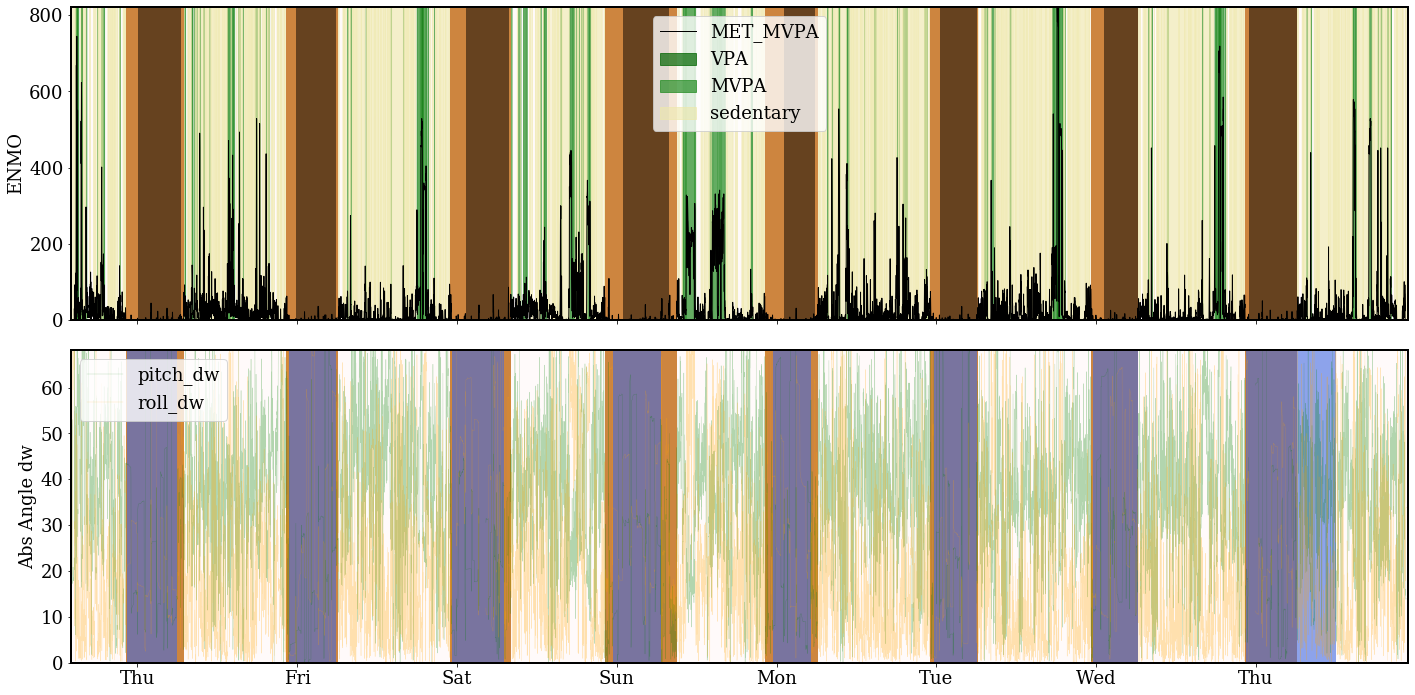

In [49]:
from population_plots import plot_algos_dw

f = plot_algos_dw(d,2,diary[3],qtl=0.4,length=25)
#f.savefig('AlgosDiaryPlot.png')
plt.show(f)

In [1]:
#f = plot_daily_vh(d,0)
#f.savefig('subject_plot.png')
#plt.show(f)
#plt.clf()